In [40]:
import pandas as pd
import numpy as np

# Carregar a planilha
file_path = "Heat Exchanger.xlsx"  # Substitua pelo caminho do seu arquivo
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Renomear colunas para facilitar o acesso
df.columns = ["Time_s", "ColdTemp_C", "HotTemp_C"]

# Converter vírgulas para pontos decimais (se necessário)
df = df.replace(",", ".", regex=True)

# Garantir que os dados são numéricos
df = df.astype(float)

# Remover valores duplicados
df = df.drop_duplicates()

# Tratar valores ausentes (preenchendo com interpolação)
df = df.interpolate()

# Normalizar os dados entre 0 e 1 para modelos de ML
df_norm = (df - df.min()) / (df.max() - df.min())

# Salvar o arquivo pré-processado
df_norm.to_csv("dados_preprocessados.csv", index=False)

print("Pré-processamento concluído. Dados salvos em 'dados_preprocessados.csv'.")

Pré-processamento concluído. Dados salvos em 'dados_preprocessados.csv'.


In [41]:
df.head()

,Time_s,ColdTemp_C,HotTemp_C
0,0.0,24.902356,69.156733
1,1.0,24.927418,69.091994
2,2.0,24.952480,69.026581
3,3.0,24.977540,68.961178
4,4.0,25.002599,68.895832


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


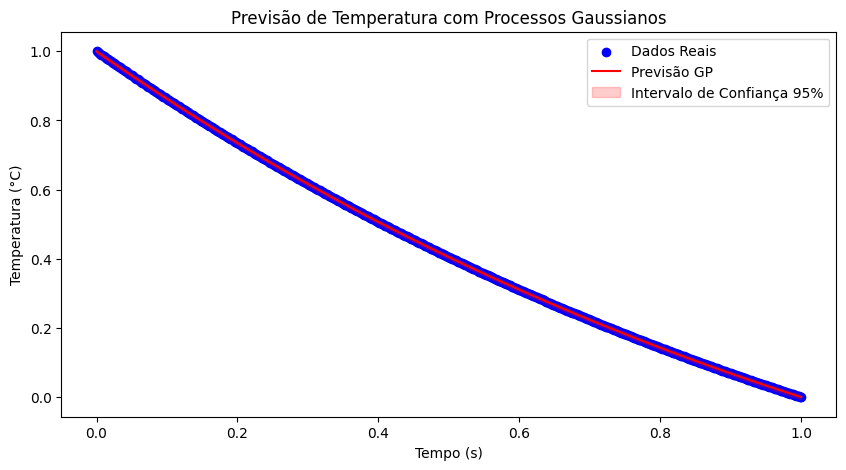

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Carregar os dados pré-processados
file_path = "dados_preprocessados.csv"  # Nome do arquivo salvo
df = pd.read_csv(file_path)

# Definir variáveis
X = df["Time_s"].values.reshape(-1, 1)  # Tempo como entrada
y = df["HotTemp_C"].values.reshape(-1, 1)  # Temperatura quente como saída

# Definir o modelo de Processos Gaussianos
kernel = RBF(length_scale=5.0) + WhiteKernel(noise_level=0.01)  # Kernel para suavidade e ruído
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Treinar o modelo
gp.fit(X, y)

# Fazer previsões
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Novos pontos no tempo
y_pred, sigma = gp.predict(X_pred, return_std=True)  # Previsões com intervalo de incerteza

# Plotar os resultados
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Dados Reais", color="blue")
plt.plot(X_pred, y_pred, label="Previsão GP", color="red")
plt.fill_between(X_pred.ravel(), y_pred.ravel() - 1.96 * sigma, y_pred.ravel() + 1.96 * sigma,
                 alpha=0.2, color="red", label="Intervalo de Confiança 95%")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão de Temperatura com Processos Gaussianos")
plt.legend()
plt.show()

# A previsão com Processos Gaussianos parece estar ajustada aos dados, mas o intervalo de confiança está muito estreito, o que pode indicar que o modelo está excessivamente confiante.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


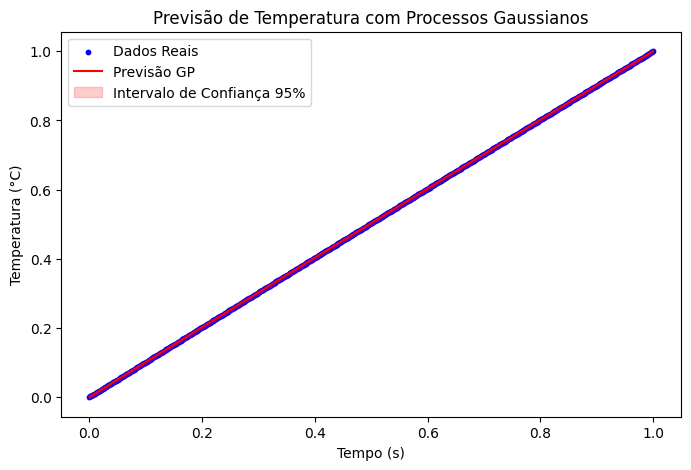

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import MinMaxScaler

# Carregar os dados pré-processados
df = pd.read_csv("dados_preprocessados.csv")

# Separar variáveis
X = df["Time_s"].values.reshape(-1, 1)
y = df["ColdTemp_C"].values.reshape(-1, 1)

# Normalizar os dados
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Definir kernel ajustado
kernel = RBF(length_scale=10.0) + WhiteKernel(noise_level=0.05)

# Criar modelo GP
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_scaled, y_scaled.ravel())

# Fazer previsões
X_pred = np.linspace(X_scaled.min(), X_scaled.max(), 100).reshape(-1, 1)
y_pred, y_std = gp.predict(X_pred, return_std=True)

# Desnormalizar previsões
X_pred_original = scaler_x.inverse_transform(X_pred)
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_std_original = scaler_y.inverse_transform((y_pred + 1.96 * y_std).reshape(-1, 1)) - y_pred_original

# Plotar os resultados
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color="blue", label="Dados Reais", s=10)
plt.plot(X_pred_original, y_pred_original, color="red", label="Previsão GP")
plt.fill_between(X_pred_original.ravel(), 
                 (y_pred_original - y_std_original).ravel(), 
                 (y_pred_original + y_std_original).ravel(), 
                 color="red", alpha=0.2, label="Intervalo de Confiança 95%")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão de Temperatura com Processos Gaussianos")
plt.legend()
plt.show()

In [44]:
from sklearn.gaussian_process.kernels import Matern

kernel = RBF(length_scale=10.0) + Matern(length_scale=5.0, nu=1.5) + WhiteKernel(noise_level=0.05)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


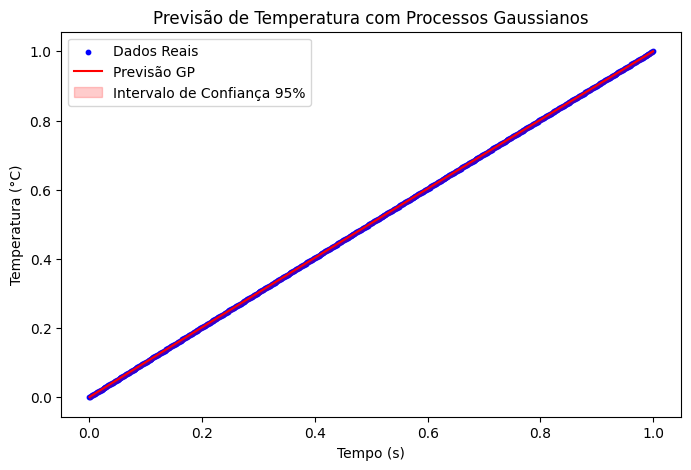

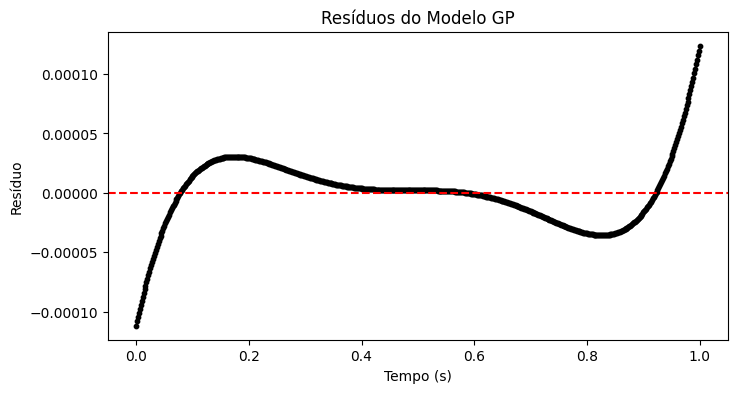

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.preprocessing import MinMaxScaler

# Carregar os dados
file_path = "dados_preprocessados.csv"
df = pd.read_csv(file_path)

# Separar variáveis
X = df["Time_s"].values.reshape(-1, 1)
y = df["ColdTemp_C"].values.reshape(-1, 1)

# Verificar normalização
y_min, y_max = y.min(), y.max()
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Definir o kernel mais complexo
kernel = RBF(length_scale=10.0) + Matern(length_scale=5.0, nu=1.5) + WhiteKernel(noise_level=0.05)

# Criar e treinar o modelo GP
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_scaled, y_scaled.ravel())

# Fazer previsões
X_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_pred_scaled = scaler_X.transform(X_pred)
y_pred_scaled, sigma_scaled = gp.predict(X_pred_scaled, return_std=True)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
sigma = scaler_y.inverse_transform((y_pred_scaled + sigma_scaled).reshape(-1, 1)) - y_pred

# Plotar previsões
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label="Dados Reais", s=10)
plt.plot(X_pred, y_pred, color='red', label="Previsão GP")
plt.fill_between(X_pred.ravel(), (y_pred - 1.96 * sigma).ravel(), (y_pred + 1.96 * sigma).ravel(),
                 color='red', alpha=0.2, label="Intervalo de Confiança 95%")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão de Temperatura com Processos Gaussianos")
plt.legend()
plt.show()

# Plotar os resíduos
residuos = y - gp.predict(X_scaled).reshape(-1, 1)
plt.figure(figsize=(8, 4))
plt.scatter(X, residuos, color='black', s=10)
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Tempo (s)")
plt.ylabel("Resíduo")
plt.title("Resíduos do Modelo GP")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


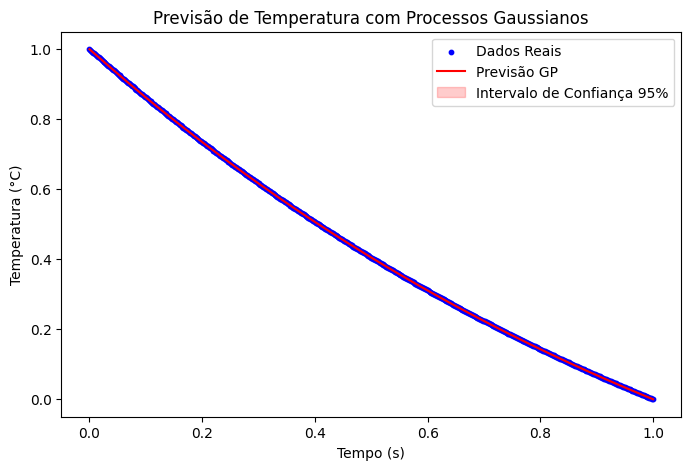

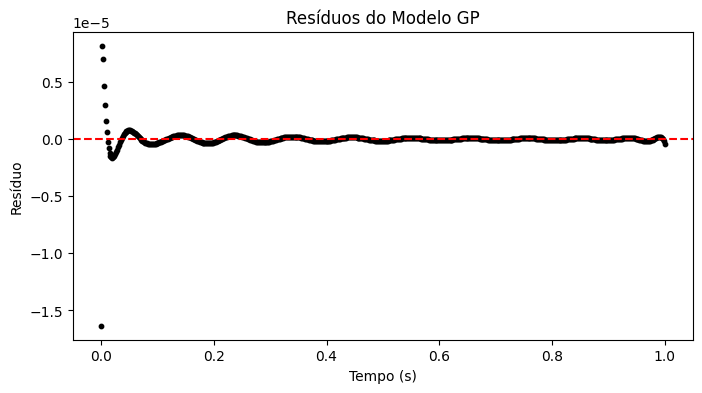

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Carregar os dados
df = pd.read_csv("dados_preprocessados.csv")

# Separar variáveis
X = df["Time_s"].values.reshape(-1, 1)
y = df["HotTemp_C"].values.reshape(-1, 1)

# Normalizar os dados com StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Definição do kernel e modelo GP
kernel = C(1.0) * RBF(length_scale=1.0)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, optimizer="fmin_l_bfgs_b")

# Treinar o modelo
gp.fit(X_scaled, y_scaled.ravel())

# Fazer previsões
y_pred_scaled, sigma_scaled = gp.predict(X_scaled, return_std=True)

# Converter previsões de volta para a escala original
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
sigma = sigma_scaled.reshape(-1, 1) * scaler_y.scale_

# Plotar os resultados
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color="blue", label="Dados Reais", s=10)
plt.plot(X, y_pred, color="red", label="Previsão GP", linewidth=1.5)
plt.fill_between(X.ravel(), 
                 (y_pred - 1.96 * sigma).ravel(), 
                 (y_pred + 1.96 * sigma).ravel(), 
                 color="red", alpha=0.2, label="Intervalo de Confiança 95%")

plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão de Temperatura com Processos Gaussianos")
plt.legend()
plt.show()

# Cálculo e plotagem dos resíduos
residuos = y - y_pred

plt.figure(figsize=(8, 4))
plt.scatter(X, residuos, color="black", s=10)
plt.axhline(y=0, color="red", linestyle="dashed")
plt.xlabel("Tempo (s)")
plt.ylabel("Resíduo")
plt.title("Resíduos do Modelo GP")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


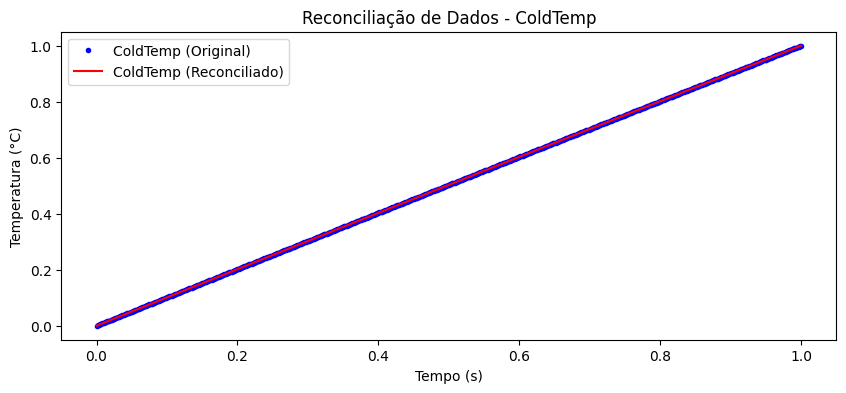

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Carregar os dados pré-processados
file_path = "dados_preprocessados.csv"
df = pd.read_csv(file_path)

# Separar variáveis
X = df["Time_s"].values.reshape(-1, 1)
y_cold = df["ColdTemp_C"].values
y_hot = df["HotTemp_C"].values

# Definir kernel para o modelo GP
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Criar e ajustar o modelo GP para cada variável
gp_cold = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_hot = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_cold.fit(X, y_cold)
gp_hot.fit(X, y_hot)

# Fazer previsões e calcular incertezas
y_cold_pred, sigma_cold = gp_cold.predict(X, return_std=True)
y_hot_pred, sigma_hot = gp_hot.predict(X, return_std=True)

# Criar DataFrame com os dados reconciliados
df_reconciled = pd.DataFrame({
    "Time_s": df["Time_s"],
    "ColdTemp_Reconciled": y_cold_pred,
    "HotTemp_Reconciled": y_hot_pred
})

# Salvar os dados reconciliados
df_reconciled.to_csv("dados_reconciliados.csv", index=False)

# Plotagem dos resultados
plt.figure(figsize=(10, 4))
plt.plot(X, y_cold, "bo", markersize=3, label="ColdTemp (Original)")
plt.plot(X, y_cold_pred, "r-", label="ColdTemp (Reconciliado)")
plt.fill_between(X.ravel(), y_cold_pred - 1.96 * sigma_cold, y_cold_pred + 1.96 * sigma_cold, color="r", alpha=0.2)
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.title("Reconciliação de Dados - ColdTemp")
plt.show()


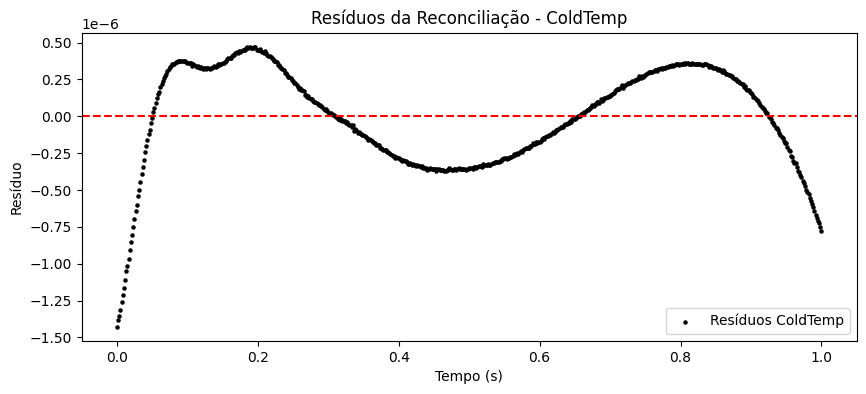

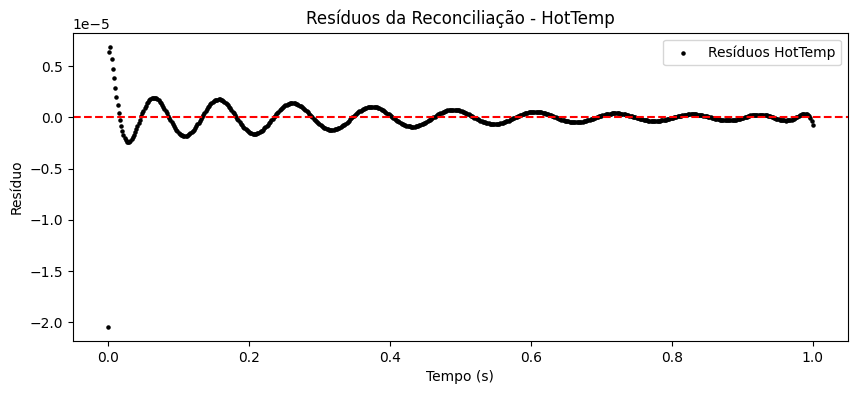

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados originais e reconciliados
df_original = pd.read_csv("dados_preprocessados.csv")
df_reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular resíduos
residuos_cold = df_original["ColdTemp_C"] - df_reconciled["ColdTemp_Reconciled"]
residuos_hot = df_original["HotTemp_C"] - df_reconciled["HotTemp_Reconciled"]

# Criar gráfico de resíduos
plt.figure(figsize=(10, 4))
plt.scatter(df_original["Time_s"], residuos_cold, color="black", s=5, label="Resíduos ColdTemp")
plt.axhline(y=0, color="red", linestyle="dashed")
plt.xlabel("Tempo (s)")
plt.ylabel("Resíduo")
plt.legend()
plt.title("Resíduos da Reconciliação - ColdTemp")
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(df_original["Time_s"], residuos_hot, color="black", s=5, label="Resíduos HotTemp")
plt.axhline(y=0, color="red", linestyle="dashed")
plt.xlabel("Tempo (s)")
plt.ylabel("Resíduo")
plt.legend()
plt.title("Resíduos da Reconciliação - HotTemp")
plt.show()

ColdTemp -> Média dos resíduos: -3.44e-09, Desvio Padrão: 3.42e-07
HotTemp  -> Média dos resíduos: 2.34e-12, Desvio Padrão: 1.26e-06


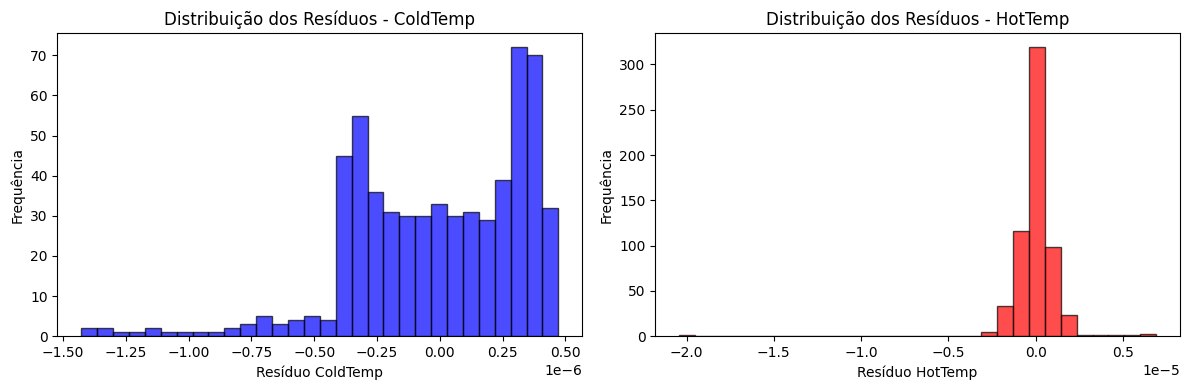


Teste de Normalidade (Shapiro-Wilk)
ColdTemp -> Estatística: 0.915, p-valor: 0.000
HotTemp  -> Estatística: 0.618, p-valor: 0.000
ColdTemp: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)
HotTemp: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Carregar os dados originais e reconciliados
df_original = pd.read_csv("dados_preprocessados.csv")
df_reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular os resíduos
residuos_cold = df_original["ColdTemp_C"] - df_reconciled["ColdTemp_Reconciled"]
residuos_hot = df_original["HotTemp_C"] - df_reconciled["HotTemp_Reconciled"]

# Cálculo da média e do desvio padrão dos resíduos
media_cold, std_cold = np.mean(residuos_cold), np.std(residuos_cold)
media_hot, std_hot = np.mean(residuos_hot), np.std(residuos_hot)

print(f"ColdTemp -> Média dos resíduos: {media_cold:.2e}, Desvio Padrão: {std_cold:.2e}")
print(f"HotTemp  -> Média dos resíduos: {media_hot:.2e}, Desvio Padrão: {std_hot:.2e}")

# Plotagem dos histogramas dos resíduos
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(residuos_cold, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Resíduo ColdTemp")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos - ColdTemp")

plt.subplot(1, 2, 2)
plt.hist(residuos_hot, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.xlabel("Resíduo HotTemp")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos - HotTemp")

plt.tight_layout()
plt.show()

# Teste de normalidade (Shapiro-Wilk)
stat_cold, p_cold = shapiro(residuos_cold)
stat_hot, p_hot = shapiro(residuos_hot)

print("\nTeste de Normalidade (Shapiro-Wilk)")
print(f"ColdTemp -> Estatística: {stat_cold:.3f}, p-valor: {p_cold:.3f}")
print(f"HotTemp  -> Estatística: {stat_hot:.3f}, p-valor: {p_hot:.3f}")

# Interpretação do p-valor
alpha = 0.05
if p_cold > alpha:
    print("ColdTemp: Os resíduos seguem distribuição normal (não rejeitamos H0)")
else:
    print("ColdTemp: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)")

if p_hot > alpha:
    print("HotTemp: Os resíduos seguem distribuição normal (não rejeitamos H0)")
else:
    print("HotTemp: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)")

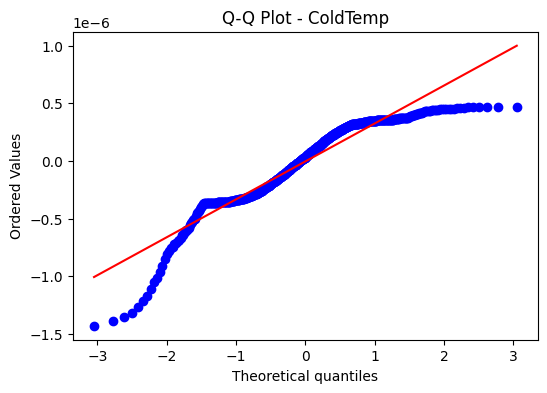

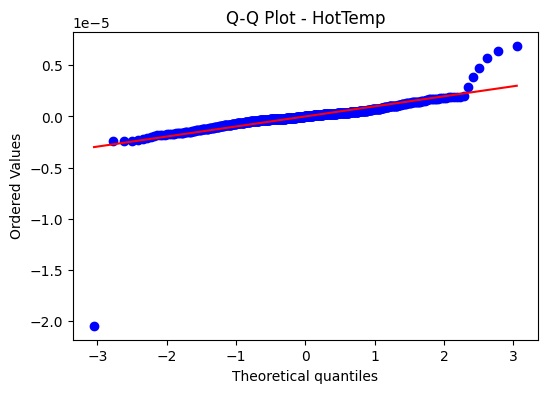

ColdTemp -> KS Estatística: 0.097, p-valor: 0.000
ColdTemp: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)

HotTemp -> KS Estatística: 0.138, p-valor: 0.000
HotTemp: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)

ColdTemp: Lambda ótimo para Box-Cox: 1016461.279


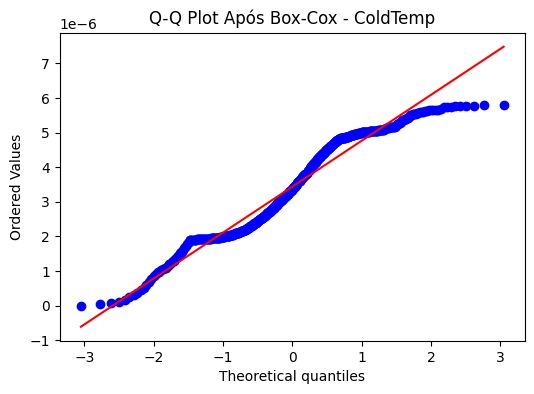

HotTemp: Lambda ótimo para Box-Cox: 76065.609


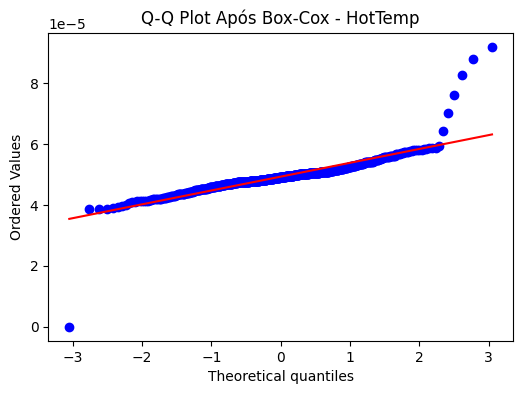

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest, boxcox

# Carregar os dados
original = pd.read_csv("dados_preprocessados.csv")
reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular os resíduos
residuos_cold = original["ColdTemp_C"] - reconciled["ColdTemp_Reconciled"]
residuos_hot = original["HotTemp_C"] - reconciled["HotTemp_Reconciled"]

# 1. Q-Q Plot
def plot_qq(data, title):
    plt.figure(figsize=(6, 4))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(title)
    plt.show()

plot_qq(residuos_cold, "Q-Q Plot - ColdTemp")
plot_qq(residuos_hot, "Q-Q Plot - HotTemp")

# 2. Teste de Kolmogorov-Smirnov
def ks_test(data, label):
    stat, p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f"{label} -> KS Estatística: {stat:.3f}, p-valor: {p:.3f}")
    if p > 0.05:
        print(f"{label}: Os resíduos seguem distribuição normal (não rejeitamos H0)\n")
    else:
        print(f"{label}: Os resíduos NÃO seguem distribuição normal (rejeitamos H0)\n")

ks_test(residuos_cold, "ColdTemp")
ks_test(residuos_hot, "HotTemp")

# 3. Transformação Box-Cox
def apply_boxcox(data, label):
    # Verificar se os valores são positivos
    if np.any(data <= 0):
        data = data - np.min(data) + 1  # Ajuste para garantir valores positivos
    transformed, lambda_val = boxcox(data)
    print(f"{label}: Lambda ótimo para Box-Cox: {lambda_val:.3f}")
    plot_qq(transformed, f"Q-Q Plot Após Box-Cox - {label}")

apply_boxcox(residuos_cold, "ColdTemp")
apply_boxcox(residuos_hot, "HotTemp")

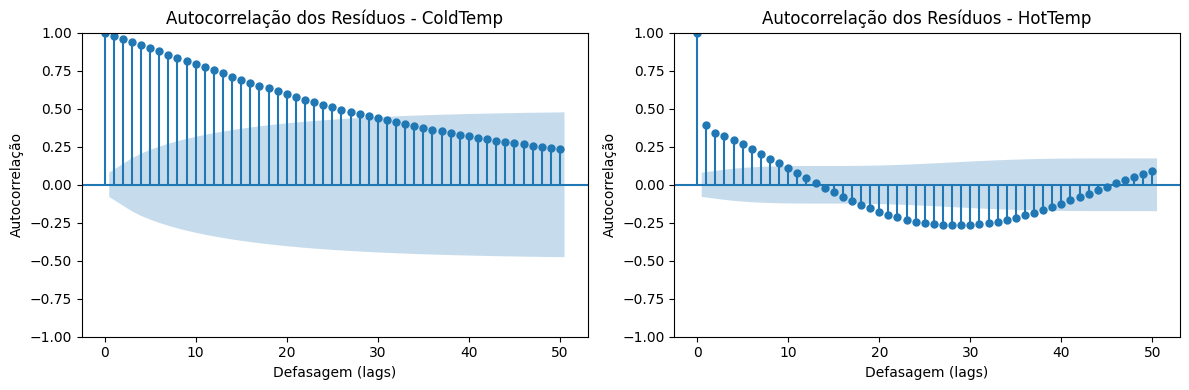


Teste de Ljung-Box para Resíduos ColdTemp:
        lb_stat  lb_pvalue
10  4821.216942        0.0

Teste de Ljung-Box para Resíduos HotTemp:
       lb_stat     lb_pvalue
10  418.710526  9.768458e-84


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carregar os dados originais e reconciliados
df_original = pd.read_csv("dados_preprocessados.csv")
df_reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular os resíduos
residuos_cold = df_original["ColdTemp_C"] - df_reconciled["ColdTemp_Reconciled"]
residuos_hot = df_original["HotTemp_C"] - df_reconciled["HotTemp_Reconciled"]

# Plotando a função de autocorrelação (ACF)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(residuos_cold, lags=50, ax=axes[0])
axes[0].set_title("Autocorrelação dos Resíduos - ColdTemp")
axes[0].set_xlabel("Defasagem (lags)")
axes[0].set_ylabel("Autocorrelação")

plot_acf(residuos_hot, lags=50, ax=axes[1])
axes[1].set_title("Autocorrelação dos Resíduos - HotTemp")
axes[1].set_xlabel("Defasagem (lags)")
axes[1].set_ylabel("Autocorrelação")

plt.tight_layout()
plt.show()

# Teste de Ljung-Box para verificar dependência temporal nos resíduos
lb_cold = acorr_ljungbox(residuos_cold, lags=[10], return_df=True)
lb_hot = acorr_ljungbox(residuos_hot, lags=[10], return_df=True)

print("\nTeste de Ljung-Box para Resíduos ColdTemp:")
print(lb_cold)

print("\nTeste de Ljung-Box para Resíduos HotTemp:")
print(lb_hot)

Teste de Ljung-Box para Resíduos Diferenciados - ColdTemp:
        lb_stat  lb_pvalue
10  3258.740801        0.0

Teste de Ljung-Box para Resíduos Diferenciados - HotTemp:
     lb_stat  lb_pvalue
10  3.679736    0.96064


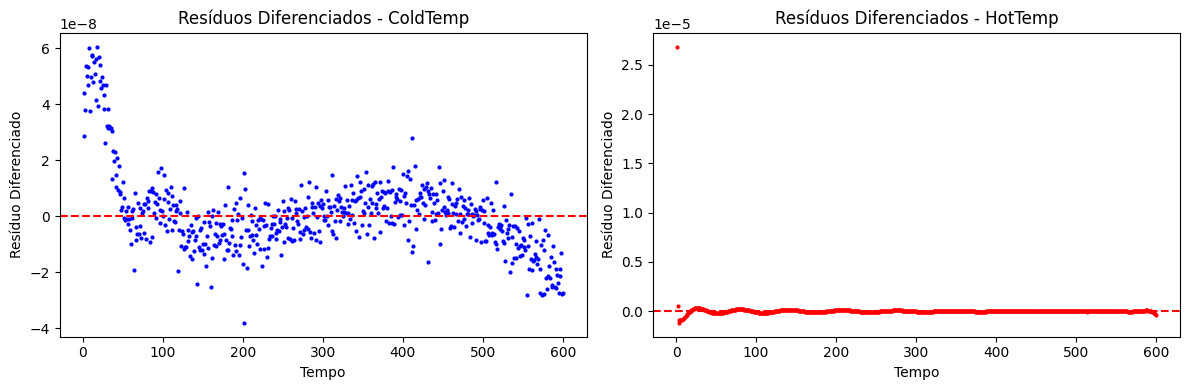

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carregar os dados originais e reconciliados
df_original = pd.read_csv("dados_preprocessados.csv")
df_reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular os resíduos
residuos_cold = df_original["ColdTemp_C"] - df_reconciled["ColdTemp_Reconciled"]
residuos_hot = df_original["HotTemp_C"] - df_reconciled["HotTemp_Reconciled"]

# Aplicar a diferenciação temporal
residuos_cold_diff = residuos_cold.diff().dropna()
residuos_hot_diff = residuos_hot.diff().dropna()

# Reaplicar o Teste de Ljung-Box nos resíduos diferenciados
ljung_cold_diff = acorr_ljungbox(residuos_cold_diff, lags=[10], return_df=True)
ljung_hot_diff = acorr_ljungbox(residuos_hot_diff, lags=[10], return_df=True)

print("Teste de Ljung-Box para Resíduos Diferenciados - ColdTemp:")
print(ljung_cold_diff)

print("\nTeste de Ljung-Box para Resíduos Diferenciados - HotTemp:")
print(ljung_hot_diff)

# Plotando os resíduos diferenciados
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(residuos_cold_diff, "bo", markersize=2)
plt.axhline(0, color="red", linestyle="dashed")
plt.xlabel("Tempo")
plt.ylabel("Resíduo Diferenciado")
plt.title("Resíduos Diferenciados - ColdTemp")

plt.subplot(1, 2, 2)
plt.plot(residuos_hot_diff, "ro", markersize=2)
plt.axhline(0, color="red", linestyle="dashed")
plt.xlabel("Tempo")
plt.ylabel("Resíduo Diferenciado")
plt.title("Resíduos Diferenciados - HotTemp")

plt.tight_layout()
plt.show()

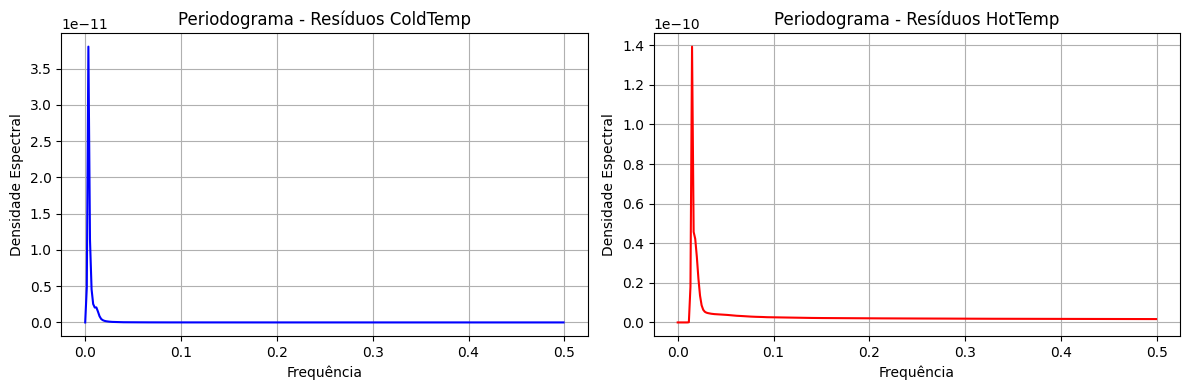

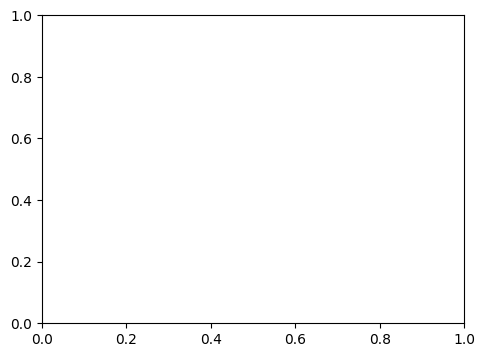

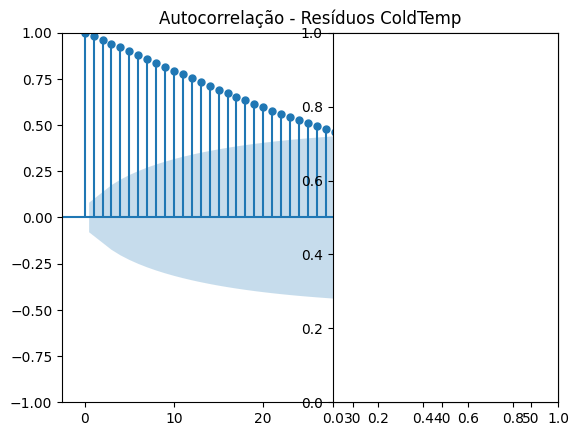

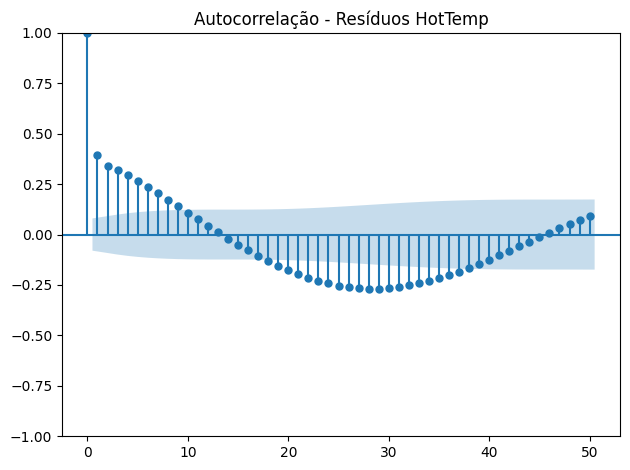

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf

# Carregar os dados originais e reconciliados
df_original = pd.read_csv("dados_preprocessados.csv")
df_reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular os resíduos
residuos_cold = df_original["ColdTemp_C"] - df_reconciled["ColdTemp_Reconciled"]
residuos_hot = df_original["HotTemp_C"] - df_reconciled["HotTemp_Reconciled"]

# Gerar o periodograma
frequencies_cold, power_cold = periodogram(residuos_cold, scaling="density")
frequencies_hot, power_hot = periodogram(residuos_hot, scaling="density")

# Plotando o periodograma
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(frequencies_cold, power_cold, color='blue')
plt.xlabel("Frequência")
plt.ylabel("Densidade Espectral")
plt.title("Periodograma - Resíduos ColdTemp")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(frequencies_hot, power_hot, color='red')
plt.xlabel("Frequência")
plt.ylabel("Densidade Espectral")
plt.title("Periodograma - Resíduos HotTemp")
plt.grid()

plt.tight_layout()
plt.show()

# Função de Autocorrelação (ACF)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(residuos_cold, lags=50)
plt.title("Autocorrelação - Resíduos ColdTemp")

plt.subplot(1, 2, 2)
plot_acf(residuos_hot, lags=50)
plt.title("Autocorrelação - Resíduos HotTemp")

plt.tight_layout()
plt.show()

Teste de Dickey-Fuller para ColdTemp:
Estatística de Teste: 0.2682
Valor-p: 0.9758
Valores Críticos: {'1%': -3.441635870156286, '5%': -2.866518854162241, '10%': -2.569421591856497}
ColdTemp NÃO é estacionária.
Teste de Dickey-Fuller para HotTemp:
Estatística de Teste: 5.6008
Valor-p: 1.0000
Valores Críticos: {'1%': -3.4416553818946145, '5%': -2.8665274458710064, '10%': -2.5694261699959413}
HotTemp NÃO é estacionária.

Resumo do Modelo ARIMA para ColdTemp:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  601
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6364.753
Date:                Fri, 21 Mar 2025   AIC                         -12721.507
Time:                        15:06:54   BIC                         -12703.912
Sample:                             0   HQIC                        -12714.658
                                - 601                             

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


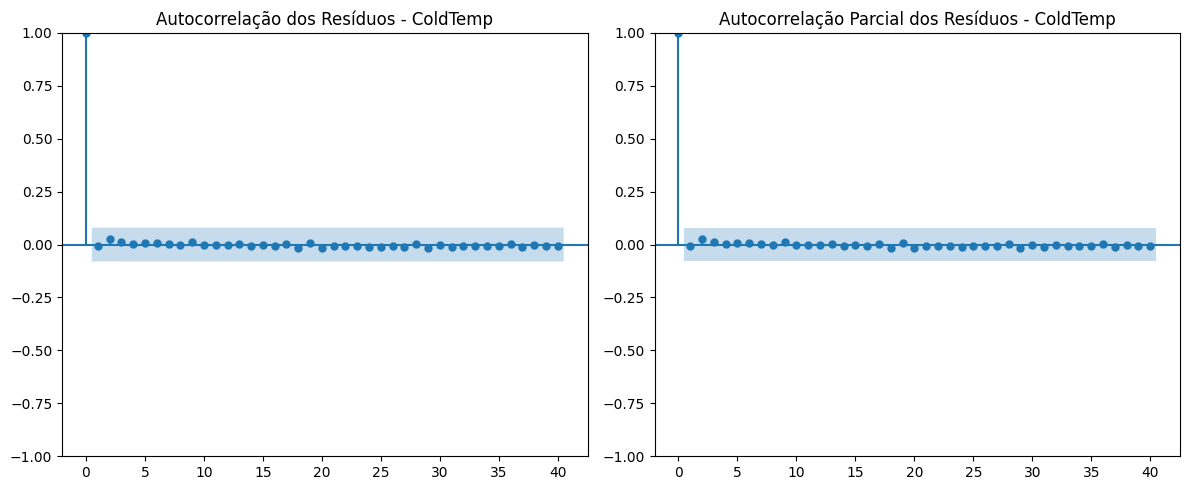

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Resumo do Modelo ARIMA para HotTemp:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  601
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6362.494
Date:                Fri, 21 Mar 2025   AIC                         -12716.988
Time:                        15:06:54   BIC                         -12699.394
Sample:                             0   HQIC                        -12710.140
                                - 601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.34e-12   2.69e-05    8.7e-08      1.000   -5.27e-05    5.27e-05
ar.L1          0.9205   6.84e-10   1.35e+09      0.000       0.920       0.920
ma.L1         

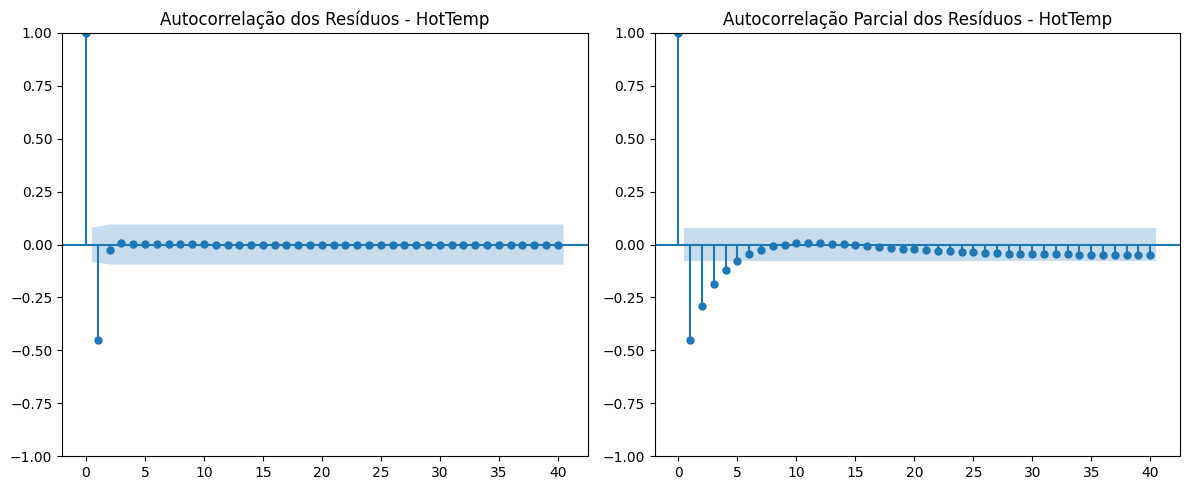

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Carregar os dados
df_original = pd.read_csv("dados_preprocessados.csv")
df_reconciled = pd.read_csv("dados_reconciliados.csv")

# Calcular os resíduos
residuos_cold = df_original["ColdTemp_C"] - df_reconciled["ColdTemp_Reconciled"]
residuos_hot = df_original["HotTemp_C"] - df_reconciled["HotTemp_Reconciled"]

# Teste de estacionariedade - Dickey-Fuller
def testar_estacionariedade(series, nome):
    resultado = adfuller(series)
    print(f"Teste de Dickey-Fuller para {nome}:")
    print(f"Estatística de Teste: {resultado[0]:.4f}")
    print(f"Valor-p: {resultado[1]:.4f}")
    print(f"Valores Críticos: {resultado[4]}")
    if resultado[1] < 0.05:
        print(f"{nome} é estacionária.")
    else:
        print(f"{nome} NÃO é estacionária.")

testar_estacionariedade(residuos_cold, "ColdTemp")
testar_estacionariedade(residuos_hot, "HotTemp")

# Definir função para ajuste de ARIMA
def ajustar_arima(residuos, nome):
    modelo = ARIMA(residuos, order=(1, 0, 1))  # Ordem pode ser ajustada com base em ACF/PACF
    modelo_fit = modelo.fit()
    print(f"\nResumo do Modelo ARIMA para {nome}:")
    print(modelo_fit.summary())

    # Diagnóstico dos resíduos
    residuos_modelo = modelo_fit.resid
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(residuos_modelo, lags=40, ax=plt.gca())
    plt.title(f"Autocorrelação dos Resíduos - {nome}")

    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_pacf(residuos_modelo, lags=40, ax=plt.gca())
    plt.title(f"Autocorrelação Parcial dos Resíduos - {nome}")

    plt.tight_layout()
    plt.show()

# Ajustar modelo ARIMA para cada série de resíduos
ajustar_arima(residuos_cold, "ColdTemp")
ajustar_arima(residuos_hot, "HotTemp")

Teste de Dickey-Fuller para ColdTemp (Diferenciado):
Estatística de Teste: -5.5410
Valor-p: 0.0000
Valores Críticos: {'1%': -3.4416749612171467, '5%': -2.8665360672844318, '10%': -2.5694307639714626}
ColdTemp (Diferenciado) é estacionária.
Teste de Dickey-Fuller para HotTemp (Diferenciado):
Estatística de Teste: -0.4631
Valor-p: 0.8990
Valores Críticos: {'1%': -3.441635870156286, '5%': -2.866518854162241, '10%': -2.569421591856497}
HotTemp (Diferenciado) NÃO é estacionária.


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete


Resumo do Modelo ARIMA para ColdTemp (Diferenciado):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6382.772
Date:                Fri, 21 Mar 2025   AIC                         -12757.544
Time:                        15:06:54   BIC                         -12739.956
Sample:                             0   HQIC                        -12750.697
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.823e-06   3.03e-05     -0.159      0.874   -6.43e-05    5.46e-05
ar.L1       1.435e-16   9.71e-12   1.48e-05      1.000    -1.9e-11     1.9e-1

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


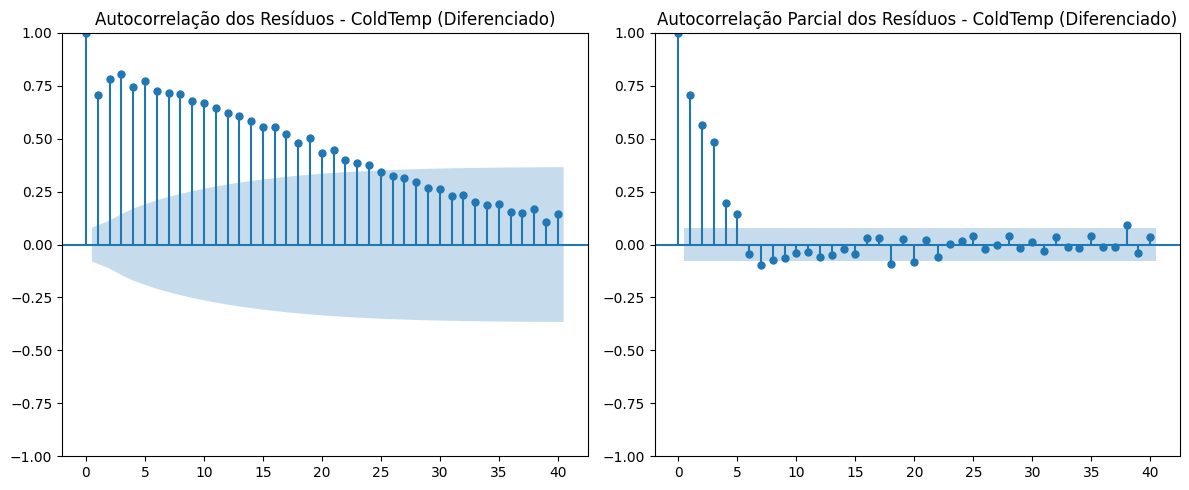

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Resumo do Modelo ARIMA para HotTemp (Diferenciado):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6351.577
Date:                Fri, 21 Mar 2025   AIC                         -12695.154
Time:                        15:06:55   BIC                         -12677.566
Sample:                             0   HQIC                        -12688.307
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.286e-08   5.42e-05      0.001      1.000      -0.000       0.000
ar.L1          0.9308   7.49e-09   1.24e+08      0.000       0.931       0.931

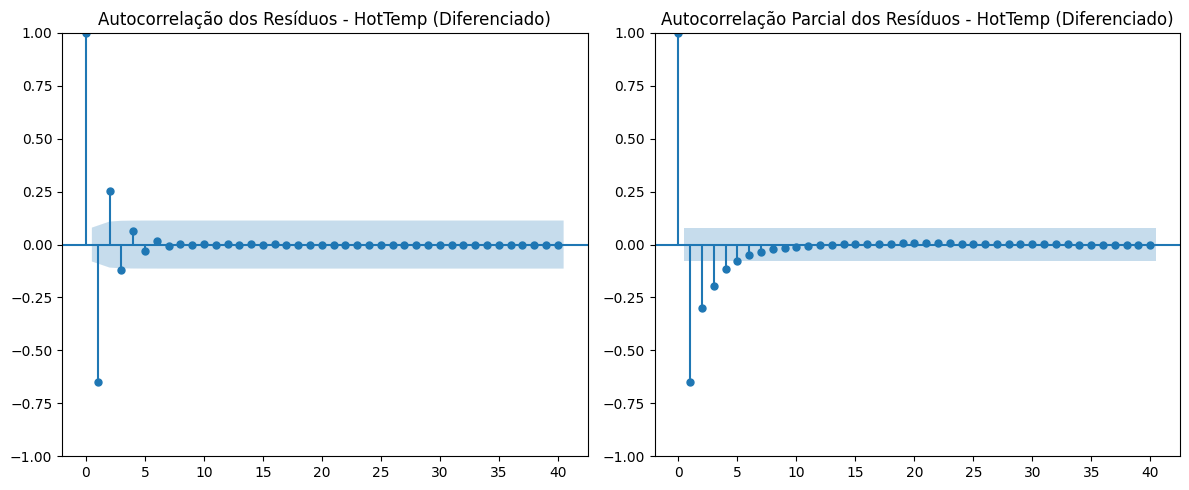

In [55]:
# Aplicar a diferenciação (ordem 1)
residuos_cold_diff = residuos_cold.diff().dropna()
residuos_hot_diff = residuos_hot.diff().dropna()

# Testar estacionariedade novamente após a diferenciação
testar_estacionariedade(residuos_cold_diff, "ColdTemp (Diferenciado)")
testar_estacionariedade(residuos_hot_diff, "HotTemp (Diferenciado)")

# Ajustar modelo ARIMA na série diferenciada
ajustar_arima(residuos_cold_diff, "ColdTemp (Diferenciado)")
ajustar_arima(residuos_hot_diff, "HotTemp (Diferenciado)")

Teste de Dickey-Fuller para HotTemp (Diferenciado 2x):
Estatística de Teste: 1.9845
Valor-p: 0.9987
Valores Críticos: {'1%': -3.441694608475642, '5%': -2.866544718556839, '10%': -2.5694353738653684}
HotTemp (Diferenciado 2x) NÃO é estacionária.

Resumo do Modelo ARIMA para HotTemp (Diferenciado 2x):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  599
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6341.586
Date:                Fri, 21 Mar 2025   AIC                         -12675.172
Time:                        15:06:55   BIC                         -12657.591
Sample:                             0   HQIC                        -12668.328
                                - 599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


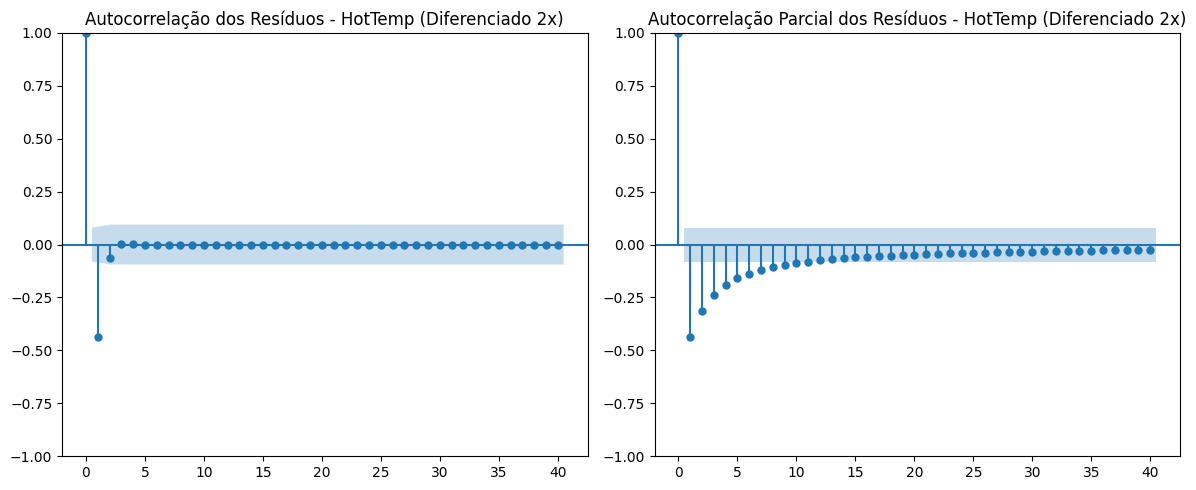

In [56]:
# Aplicar mais uma diferenciação na série HotTemp
residuos_hot_diff2 = residuos_hot_diff.diff().dropna()

# Testar estacionariedade novamente para HotTemp diferenciado duas vezes
testar_estacionariedade(residuos_hot_diff2, "HotTemp (Diferenciado 2x)")

# Se estacionária, ajustar ARIMA
ajustar_arima(residuos_hot_diff2, "HotTemp (Diferenciado 2x)")

In [57]:
# Aplicar transformação logarítmica com um pequeno deslocamento para evitar log(0)
c = 1e-3  # Pequeno deslocamento para evitar problemas numéricos
hottemp_log = np.log(residuos_hot + c)

# Diferenciar a série transformada
hottemp_log_diff = hottemp_log.diff().dropna()

# Testar estacionariedade novamente
testar_estacionariedade(hottemp_log_diff, "HotTemp (Log Diferenciado)")

Teste de Dickey-Fuller para HotTemp (Log Diferenciado):
Estatística de Teste: -0.4654
Valor-p: 0.8986
Valores Críticos: {'1%': -3.441635870156286, '5%': -2.866518854162241, '10%': -2.569421591856497}
HotTemp (Log Diferenciado) NÃO é estacionária.


In [62]:
print(df.columns)  # Verifica os nomes das colunas disponíveis

Index(['Time_s', 'ColdTemp_C', 'HotTemp_C'], dtype='object')


In [63]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Garantindo que a série esteja no formato correto
hottemp = df["HotTemp_C"]  # Corrigindo o nome da coluna
hottemp = pd.Series(hottemp)

# Ajustando o índice para representar a série temporal
hottemp.index = pd.to_datetime(df["Time_s"], unit="s")  # Supondo que 'Time_s' está em segundos

# Aplicando o modelo de suavização exponencial (Holt-Winters)
modelo_hw = ExponentialSmoothing(hottemp, trend="add", seasonal="add", seasonal_periods=24)
ajuste_hw = modelo_hw.fit()

# Calculando resíduos
residuos_hw = hottemp - ajuste_hw.fittedvalues

# Verificando os primeiros valores dos resíduos
print(residuos_hw.head())

Time_s
1970-01-01 00:00:00.000000000   -0.000006
1970-01-01 00:00:00.001666666   -0.000030
1970-01-01 00:00:00.003333333   -0.000051
1970-01-01 00:00:00.005000000   -0.000048
1970-01-01 00:00:00.006666666   -0.000047
dtype: float64


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [64]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Garantindo que 'Time_s' seja o índice do DataFrame
df["Time_s"] = pd.to_datetime(df["Time_s"])  # Garantindo formato datetime
df.set_index("Time_s", inplace=True)  # Definindo como índice

# Selecionando a série temporal de temperatura quente
hottemp = df["HotTemp_C"]

# Aplicando o modelo Holt-Winters com suavização exponencial
modelo_hw = ExponentialSmoothing(hottemp, trend="add", seasonal="add", seasonal_periods=24)
ajuste_hw = modelo_hw.fit()

# Calculando resíduos
residuos_hw = hottemp - ajuste_hw.fittedvalues

# Verificando os primeiros valores dos resíduos
print(residuos_hw.head())

Time_s
1970-01-01   -0.000006
1970-01-01   -0.000030
1970-01-01   -0.000051
1970-01-01   -0.000048
1970-01-01   -0.000047
dtype: float64


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [66]:
print(df.columns)

Index(['ColdTemp_C', 'HotTemp_C'], dtype='object')


In [67]:
print(df.head())

            ColdTemp_C  HotTemp_C
Time_s                           
1970-01-01    0.000000   1.000000
1970-01-01    0.001687   0.997675
1970-01-01    0.003374   0.995327
1970-01-01    0.005061   0.992978
1970-01-01    0.006748   0.990632


In [68]:
df.columns = df.columns.str.strip()

In [69]:
df.reset_index(inplace=True)  # Transforma o índice de volta em coluna
df["Time_s"] = pd.to_datetime(df["Time_s"])
df.set_index("Time_s", inplace=True)  # Define novamente como índice

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


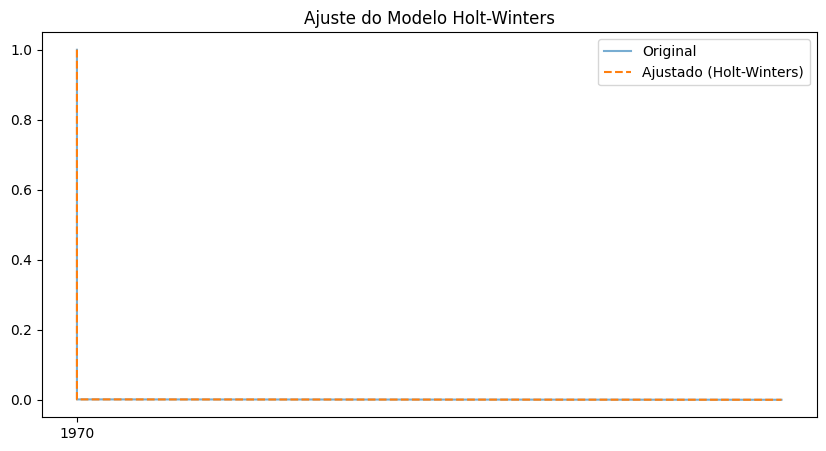

In [70]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustando o modelo Holt-Winters para a temperatura quente
modelo_hw = ExponentialSmoothing(df["HotTemp_C"], trend="add", seasonal="add", seasonal_periods=24)
ajuste_hw = modelo_hw.fit()

# Obtendo resíduos
residuos_hw = df["HotTemp_C"] - ajuste_hw.fittedvalues

# Plotando os valores ajustados
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df.index, df["HotTemp_C"], label="Original", alpha=0.6)
plt.plot(df.index, ajuste_hw.fittedvalues, label="Ajustado (Holt-Winters)", linestyle="dashed")
plt.legend()
plt.title("Ajuste do Modelo Holt-Winters")
plt.show()

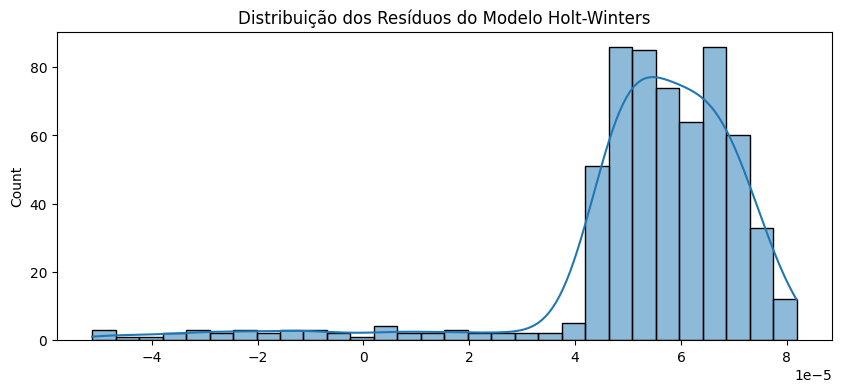

In [71]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.histplot(residuos_hw, kde=True, bins=30)
plt.title("Distribuição dos Resíduos do Modelo Holt-Winters")
plt.show()

In [72]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(residuos_hw.dropna())
print(f"Estatística de Teste: {resultado_adf[0]}")
print(f"Valor-p: {resultado_adf[1]}")
print(f"Valores Críticos: {resultado_adf[4]}")

Estatística de Teste: -3.3521406039832113
Valor-p: 0.012702696274709107
Valores Críticos: {'1%': -3.4416553818946145, '5%': -2.8665274458710064, '10%': -2.5694261699959413}


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


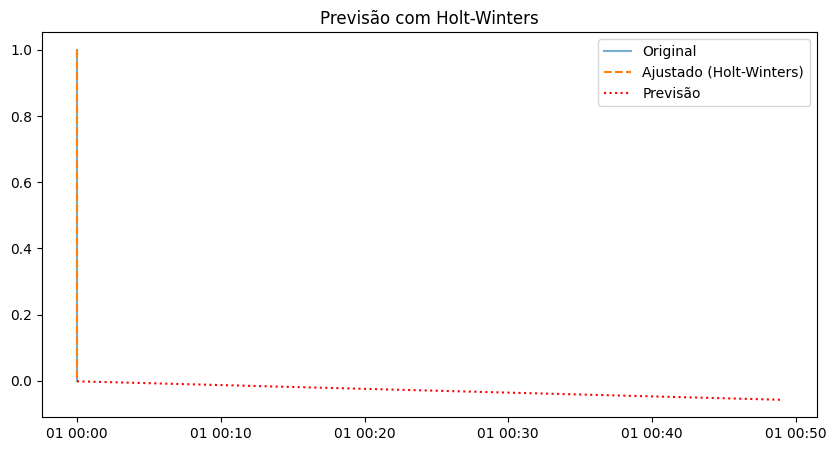

In [73]:
previsoes = ajuste_hw.forecast(steps=50)

plt.figure(figsize=(10,5))
plt.plot(df.index, df["HotTemp_C"], label="Original", alpha=0.6)
plt.plot(df.index, ajuste_hw.fittedvalues, label="Ajustado (Holt-Winters)", linestyle="dashed")
plt.plot(pd.date_range(start=df.index[-1], periods=50, freq="T"), previsoes, label="Previsão", linestyle="dotted", color="red")
plt.legend()
plt.title("Previsão com Holt-Winters")
plt.show()

In [74]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Carregar os dados
df = pd.read_csv("dados_preprocessados.csv")

# Garantir que 'Time_s' está corretamente formatado e definido como índice
if "Time_s" in df.columns:
    df["Time_s"] = pd.to_datetime(df["Time_s"], errors="coerce")
    df.set_index("Time_s", inplace=True)
else:
    raise KeyError("A coluna 'Time_s' não foi encontrada no DataFrame.")

# Verificar valores nulos e remover, se necessário
df.dropna(inplace=True)

# Selecionar série temporal para análise
coluna_alvo = "HotTemp_C"  # Altere para "ColdTemp_C" se necessário
series = df[coluna_alvo]

# Holt-Winters
modelo_hw = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=24)
ajuste_hw = modelo_hw.fit()
pred_hw = ajuste_hw.fittedvalues
mse_hw = mean_squared_error(series, pred_hw)
print(f"MSE Holt-Winters: {mse_hw}")

# ARIMA
modelo_arima = ARIMA(series, order=(1,1,1))
ajuste_arima = modelo_arima.fit()
pred_arima = ajuste_arima.fittedvalues
mse_arima = mean_squared_error(series[1:], pred_arima[1:])  # Ajustar pelo diferenciamento
print(f"MSE ARIMA: {mse_arima}")

# Comparação
melhor_modelo = "Holt-Winters" if mse_hw < mse_arima else "ARIMA"
print(f"O melhor modelo é: {melhor_modelo}")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

MSE Holt-Winters: 3.3384330869041044e-09
MSE ARIMA: 9.007727346228976e-09
O melhor modelo é: Holt-Winters


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Carregar os dados
df = pd.read_csv("dados_preprocessados.csv")

# Garantir que 'Time_s' está corretamente formatado e definido como índice
if "Time_s" in df.columns:
    df["Time_s"] = pd.to_datetime(df["Time_s"], errors="coerce")
    df.set_index("Time_s", inplace=True)
else:
    raise KeyError("A coluna 'Time_s' não foi encontrada no DataFrame.")

# Verificar valores nulos e remover, se necessário
df.dropna(inplace=True)

# Selecionar série temporal para análise
coluna_alvo = "HotTemp_C"  # Altere para "ColdTemp_C" se necessário
series = df[coluna_alvo]

# Holt-Winters
modelo_hw = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=24)
ajuste_hw = modelo_hw.fit()
pred_hw = ajuste_hw.fittedvalues
mse_hw = mean_squared_error(series, pred_hw)
print(f"MSE Holt-Winters: {mse_hw}")

# ARIMA
modelo_arima = ARIMA(series, order=(1,1,1))
ajuste_arima = modelo_arima.fit()
pred_arima = ajuste_arima.fittedvalues
mse_arima = mean_squared_error(series[1:], pred_arima[1:])  # Ajustar pelo diferenciamento
print(f"MSE ARIMA: {mse_arima}")

# Comparação
melhor_modelo = "Holt-Winters" if mse_hw < mse_arima else "ARIMA"
print(f"O melhor modelo é: {melhor_modelo}")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

MSE Holt-Winters: 3.3384330869041044e-09
MSE ARIMA: 9.007727346228976e-09
O melhor modelo é: Holt-Winters


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
